# Comparing Surveyed vs. Estimated Country-means

Ultimately, retrieving the ATE can be seen as determining the (possibly weighted) means of two subsets: treated and control. As we will see, using the mean of model predictions for the subset, $\mathbb{E}[\hat{Y} \mid i \in S]$, will be a biased estimate of $\mathbb{E}[Y \mid i \in S]$ due to $Y - \hat{Y} \not\perp Y$. To study this phenomenon, we would like to estimate the mean of some of subsets with and without our Tweedies' based debiasing formula. The subsets need to be meaningful, so in this notebook we will make use of the country labels to estimate the mean IWI for each country. The hypothesis is that the mean of the predicted estimates will be biased in regards to the true wealth, such that the predicted mean will be too high for poor countries and too low for rich countries. The hope is for the Tweedie's adjusted predictions to remove this bias.

In [ ]:
import timm
import json
import os
import torch
import pandas as pd
import numpy as np
import configparser
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

sns.set(style="darkgrid")

tqdm.pandas()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

# Set up PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("high")

# Set seeds for reproducibility
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Define the directory for end-to-end models
MODELS_DIR = os.path.join(DATA_DIR, 'end_to_end_models')
if not os.path.exists(MODELS_DIR):
    raise FileNotFoundError(f"Models directory not found at {MODELS_DIR}")

folds = ['A', 'B', 'C', 'D', 'E']

# Load the dataset with predictions
df = pd.read_csv(os.path.join(MODELS_DIR, 'dhs_with_imgs_predictions.csv'))
with open(os.path.join(MODELS_DIR, 'correction_values.json'), 'r') as f:
    correction_values = json.load(f)

In [3]:
def get_survey_means(survey_df, correction_values):

    survey_means = survey_df.groupby('cv_fold')[['iwi', 'iwi_hat', 'val_score', 'train_score']].mean().sort_values('cv_fold')

    for i, row in survey_means.iterrows():
        fold_corr_vals = correction_values[row.name]
        survey_means.loc[row.name, 'lcc_val_iwi_hat'] = (row['iwi_hat'] - fold_corr_vals['val_lcc_intercept']) / fold_corr_vals['val_lcc_slope']
        survey_means.loc[row.name, 'lcc_train_iwi_hat'] = (row['iwi_hat'] - fold_corr_vals['train_lcc_intercept']) / fold_corr_vals['train_lcc_slope']

        survey_means.loc[row.name, 'tweedie_train_iwi_hat'] = row['iwi_hat'] - fold_corr_vals['train_sigma'] ** 2 * row['train_score']
        survey_means.loc[row.name, 'tweedie_val_iwi_hat'] = row['iwi_hat'] - fold_corr_vals['val_sigma'] ** 2 * row['val_score']
        survey_means.loc[row.name, 'tweedie_iwi_hat'] = row['iwi_hat'] - fold_corr_vals['train_sigma'] ** 2 * row['val_score']

    survey_means = survey_means.drop(columns=['val_score', 'train_score'])

    return survey_means

survey_means_df = df.groupby('survey').apply(get_survey_means, correction_values=correction_values).reset_index()

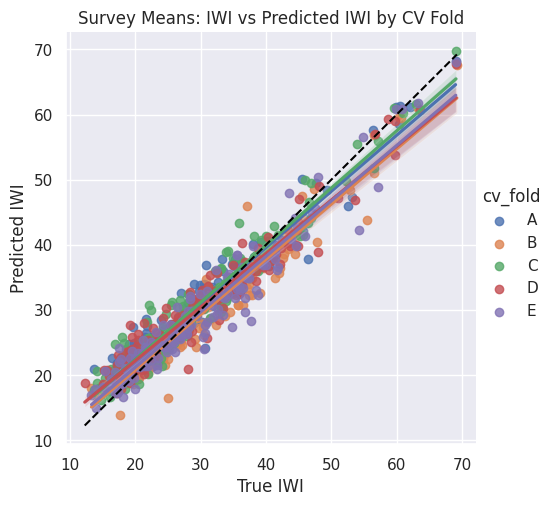

In [4]:
sns.lmplot(data=survey_means_df, x='iwi', y='iwi_hat', hue='cv_fold')
min_iwi = survey_means_df['iwi'].min()
max_iwi = survey_means_df['iwi'].max()
plt.plot([min_iwi, max_iwi], [min_iwi, max_iwi], color='black', linestyle='--')
plt.xlabel('True IWI')
plt.ylabel('Predicted IWI')
plt.title('Survey Means: IWI vs Predicted IWI by CV Fold')
plt.show()

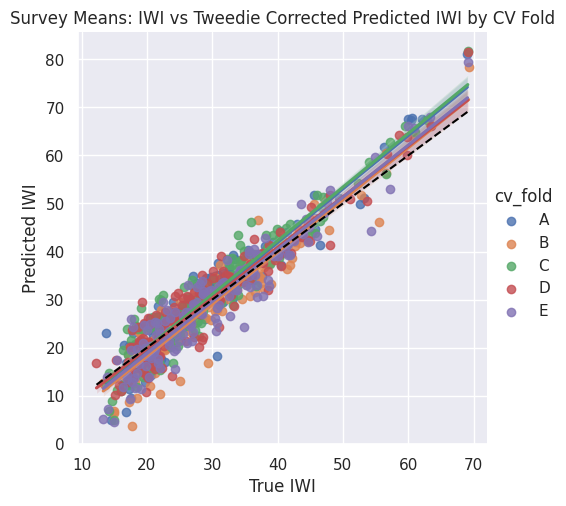

In [5]:
sns.lmplot(data=survey_means_df, x='iwi', y='tweedie_val_iwi_hat', hue='cv_fold')
min_iwi = survey_means_df['iwi'].min()
max_iwi = survey_means_df['iwi'].max()
plt.plot([min_iwi, max_iwi], [min_iwi, max_iwi], color='black', linestyle='--')
plt.xlabel('True IWI')
plt.ylabel('Predicted IWI')
plt.title('Survey Means: IWI vs Tweedie Corrected Predicted IWI by CV Fold')
plt.show()

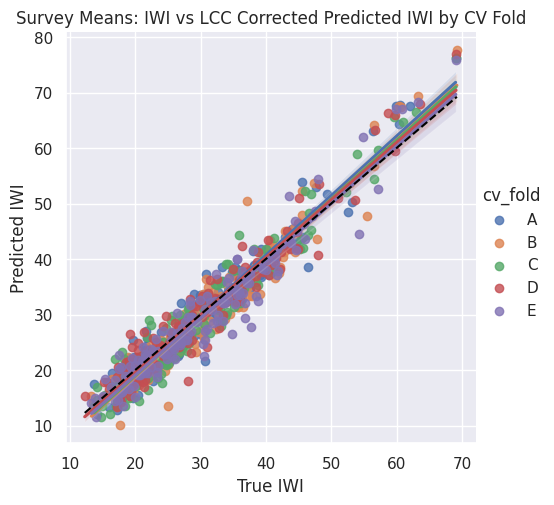

In [6]:
sns.lmplot(data=survey_means_df, x='iwi', y='lcc_val_iwi_hat', hue='cv_fold')
min_iwi = survey_means_df['iwi'].min()
max_iwi = survey_means_df['iwi'].max()
plt.plot([min_iwi, max_iwi], [min_iwi, max_iwi], color='black', linestyle='--')
plt.xlabel('True IWI')
plt.ylabel('Predicted IWI')
plt.title('Survey Means: IWI vs LCC Corrected Predicted IWI by CV Fold')
plt.show()

In [7]:
survey_means_df

,survey,cv_fold,iwi,iwi_hat,lcc_val_iwi_hat,lcc_train_iwi_hat,tweedie_train_iwi_hat,tweedie_val_iwi_hat,tweedie_iwi_hat
0,Angola 2006-07 MIS,A,30.650841,24.249497,21.561144,23.202096,23.320435,18.176446,22.973131
1,Angola 2006-07 MIS,B,29.294907,24.382344,23.335917,24.383202,22.945318,16.892020,22.671197
2,Angola 2006-07 MIS,C,27.339045,30.627385,28.929161,29.495157,29.207769,23.609069,29.079046
3,Angola 2006-07 MIS,D,23.851853,26.151100,24.537766,25.617680,23.844105,14.145162,23.717847
4,Angola 2006-07 MIS,E,24.296925,24.539196,23.118776,24.524833,23.116705,15.581235,22.733496
...,...,...,...,...,...,...,...,...,...
818,Zimbabwe 2015 Standard DHS,A,38.051273,37.835623,38.485088,37.239169,38.093055,38.815013,38.041460
819,Zimbabwe 2015 Standard DHS,B,39.035836,32.665407,33.745497,33.187737,32.847737,33.227254,32.793759
820,Zimbabwe 2015 Standard DHS,C,38.500091,36.436420,35.941194,35.370807,37.101465,39.174505,37.040480
821,Zimbabwe 2015 Standard DHS,D,39.610608,36.570316,37.655559,36.503461,36.994233,38.153960,36.891274


In [8]:
long_df = pd.melt(
    survey_means_df,
    id_vars=['survey', 'cv_fold', 'iwi'],
    value_vars=['iwi_hat', 'lcc_val_iwi_hat', 'lcc_train_iwi_hat', 'tweedie_train_iwi_hat', 'tweedie_val_iwi_hat', 'tweedie_iwi_hat'],
    var_name='pred_type',
    value_name='value'
)

long_df

,survey,cv_fold,iwi,pred_type,value
0,Angola 2006-07 MIS,A,30.650841,iwi_hat,24.249497
1,Angola 2006-07 MIS,B,29.294907,iwi_hat,24.382344
2,Angola 2006-07 MIS,C,27.339045,iwi_hat,30.627385
3,Angola 2006-07 MIS,D,23.851853,iwi_hat,26.151100
4,Angola 2006-07 MIS,E,24.296925,iwi_hat,24.539196
...,...,...,...,...,...
4933,Zimbabwe 2015 Standard DHS,A,38.051273,tweedie_iwi_hat,38.041460
4934,Zimbabwe 2015 Standard DHS,B,39.035836,tweedie_iwi_hat,32.793759
4935,Zimbabwe 2015 Standard DHS,C,38.500091,tweedie_iwi_hat,37.040480
4936,Zimbabwe 2015 Standard DHS,D,39.610608,tweedie_iwi_hat,36.891274


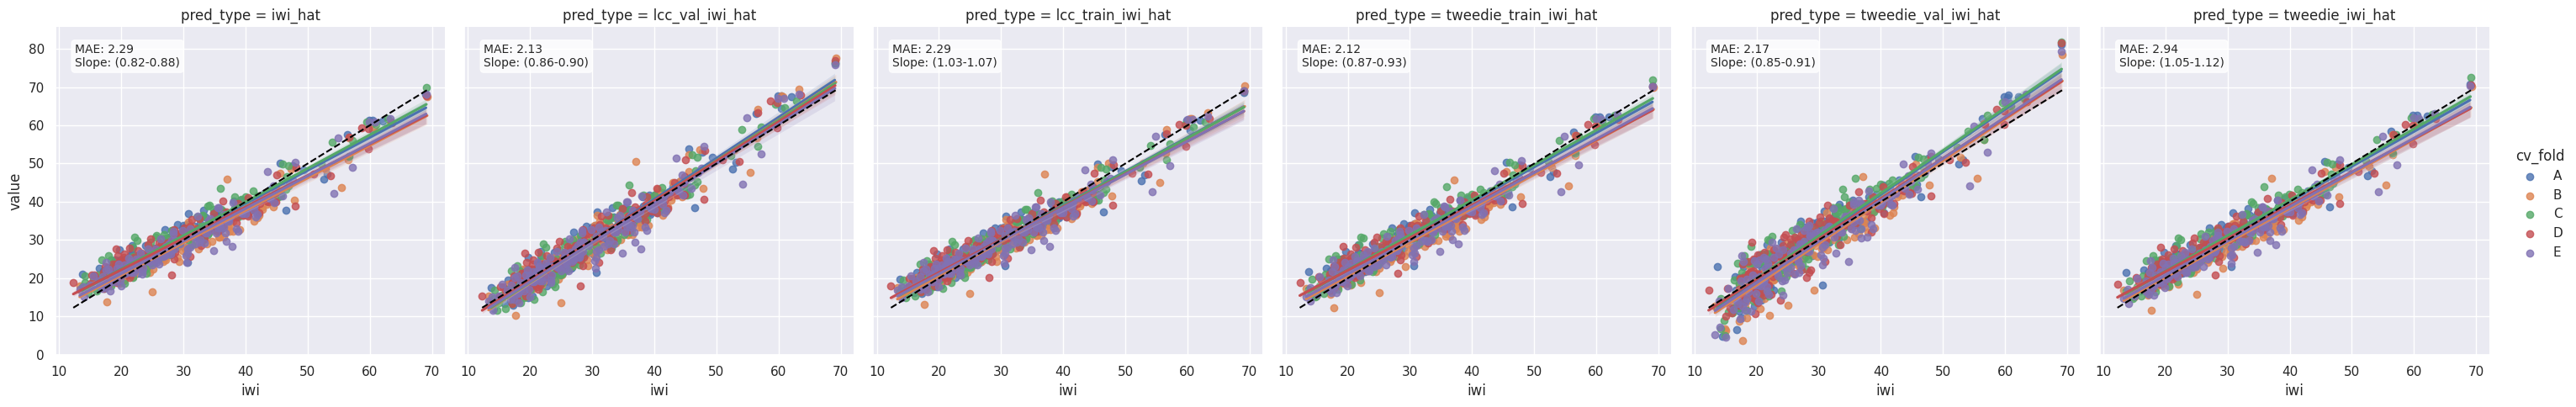

In [9]:
# Calculate MAE and mean slope for each pred_type and cv_fold
metrics = long_df.groupby(['pred_type', 'cv_fold']).apply(
    lambda group: pd.Series({
        'mae': mean_absolute_error(group['iwi'], group['value']),
        'slope': LinearRegression().fit(group[['iwi']], group['value']).coef_[0]
    })
).reset_index()

# Add the metrics to the plots
g = sns.lmplot(
    data=long_df, x="iwi", y="value",
    hue="cv_fold", col="pred_type", height=5,
    facet_kws=dict(sharex=True, sharey=True),
)

# Add the dashed line to all subplots and annotate metrics
for ax, (pred_type, group) in zip(g.axes.flat, metrics.groupby('pred_type')):
    ax.plot([min_iwi, max_iwi], [min_iwi, max_iwi], color='black', linestyle='--')
    mae = group['mae'].mean()
    min_slope = group['slope'].min()
    max_slope = group['slope'].max()
    ax.text(
        0.05, 0.95, f"MAE: {mae:.2f}\nSlope: ({min_slope:.2f}-{max_slope:.2f})",
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

plt.show()

## Compare with PPI

In [10]:
def get_survey_PPI_mean(survey_df, hold_out_frac=0.01):

    # Get a sample contaiing hold_out_frac of the data for each cv_fold
    hold_out_survey_df = survey_df.groupby('cv_fold').apply(
        lambda x: x.sample(frac=hold_out_frac, random_state=RANDOM_STATE)
    ).reset_index(drop=True)

    hold_out_survey_df['residual'] = hold_out_survey_df['iwi'] - hold_out_survey_df['iwi_hat']
    mean_residuals = hold_out_survey_df.groupby('cv_fold')['residual'].mean()

    survey_means = survey_df.groupby('cv_fold')[['iwi', 'iwi_hat']].mean().sort_values('cv_fold')
    survey_means['ppi_iwi_hat'] = survey_means['iwi_hat'] + mean_residuals
    survey_means = survey_means.drop(columns=['iwi_hat'])

    survey_means['hold_out_frac'] = hold_out_frac
    survey_means['hold_out_samples'] = hold_out_survey_df.groupby('cv_fold').size()
    return survey_means

survey_ppi_means_df = df.groupby('survey').apply(get_survey_PPI_mean).reset_index()
survey_ppi_means_df
    

,survey,cv_fold,iwi,ppi_iwi_hat,hold_out_frac,hold_out_samples
0,Angola 2006-07 MIS,A,30.650841,NaN,0.01,NaN
1,Angola 2006-07 MIS,B,29.294907,NaN,0.01,NaN
2,Angola 2006-07 MIS,C,27.339045,NaN,0.01,NaN
3,Angola 2006-07 MIS,D,23.851853,NaN,0.01,NaN
4,Angola 2006-07 MIS,E,24.296925,NaN,0.01,NaN
...,...,...,...,...,...,...
818,Zimbabwe 2015 Standard DHS,A,38.051273,64.002181,0.01,1.0
819,Zimbabwe 2015 Standard DHS,B,39.035836,26.316850,0.01,1.0
820,Zimbabwe 2015 Standard DHS,C,38.500091,35.942442,0.01,1.0
821,Zimbabwe 2015 Standard DHS,D,39.610608,43.124362,0.01,1.0


In [11]:
survey_ppi_means_df.dropna()

,survey,cv_fold,iwi,ppi_iwi_hat,hold_out_frac,hold_out_samples
7,Angola 2011 MIS,C,24.696782,19.464423,0.01,1.0
10,Angola 2015-16 Standard DHS,A,34.835594,32.215702,0.01,1.0
11,Angola 2015-16 Standard DHS,B,31.903721,44.678465,0.01,1.0
12,Angola 2015-16 Standard DHS,C,36.739058,35.707512,0.01,1.0
13,Angola 2015-16 Standard DHS,D,38.514623,45.119207,0.01,1.0
...,...,...,...,...,...,...
818,Zimbabwe 2015 Standard DHS,A,38.051273,64.002181,0.01,1.0
819,Zimbabwe 2015 Standard DHS,B,39.035836,26.316850,0.01,1.0
820,Zimbabwe 2015 Standard DHS,C,38.500091,35.942442,0.01,1.0
821,Zimbabwe 2015 Standard DHS,D,39.610608,43.124362,0.01,1.0


In [12]:
survey_ppi_means_df.dropna(inplace=True)

survey_ppi_means_df.groupby('cv_fold').apply(
    lambda group: pd.Series({
        'mae': mean_absolute_error(group['iwi'], group['ppi_iwi_hat']),
        'slope': LinearRegression().fit(group[['iwi']], group['ppi_iwi_hat']).coef_[0]
    })
).reset_index()

,cv_fold,mae,slope
0,A,6.164629,0.976963
1,B,6.372835,1.045332
2,C,5.586242,0.984491
3,D,6.130325,0.990708
4,E,7.179595,1.112481


In [31]:
hold_out_fracs = np.linspace(0.01, 1.0, 50)

ppi_stats = []

for frac in tqdm(hold_out_fracs):
    survey_ppi_means_df = df.groupby('survey').apply(get_survey_PPI_mean, hold_out_frac=frac).reset_index()

    n_surveys = survey_ppi_means_df['survey'].nunique()

    survey_ppi_means_df.dropna(inplace=True)

    ppi_metrics = survey_ppi_means_df.groupby('cv_fold').apply(
        lambda group: pd.Series({
            'mae': mean_absolute_error(group['iwi'], group['ppi_iwi_hat']),
            'slope': LinearRegression().fit(group[['iwi']], group['ppi_iwi_hat']).coef_[0],
            'hold_out_frac': frac,
            'n_dropped_surveys': n_surveys - group['survey'].nunique(),
        })
    ).reset_index()

    ppi_stats.append(ppi_metrics)
    
ppi_stats_df = pd.concat(ppi_stats, ignore_index=True)
ppi_stats_df

100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


,cv_fold,mae,slope,hold_out_frac,n_dropped_surveys
0,A,6.164629e+00,0.976963,0.01,52.0
1,B,6.372835e+00,1.045332,0.01,58.0
2,C,5.586242e+00,0.984491,0.01,52.0
3,D,6.130325e+00,0.990708,0.01,50.0
4,E,7.179595e+00,1.112481,0.01,49.0
...,...,...,...,...,...
245,A,2.131628e-15,1.000000,1.00,0.0
246,B,1.851717e-15,1.000000,1.00,0.0
247,C,1.980907e-15,1.000000,1.00,0.0
248,D,2.122963e-15,1.000000,1.00,1.0


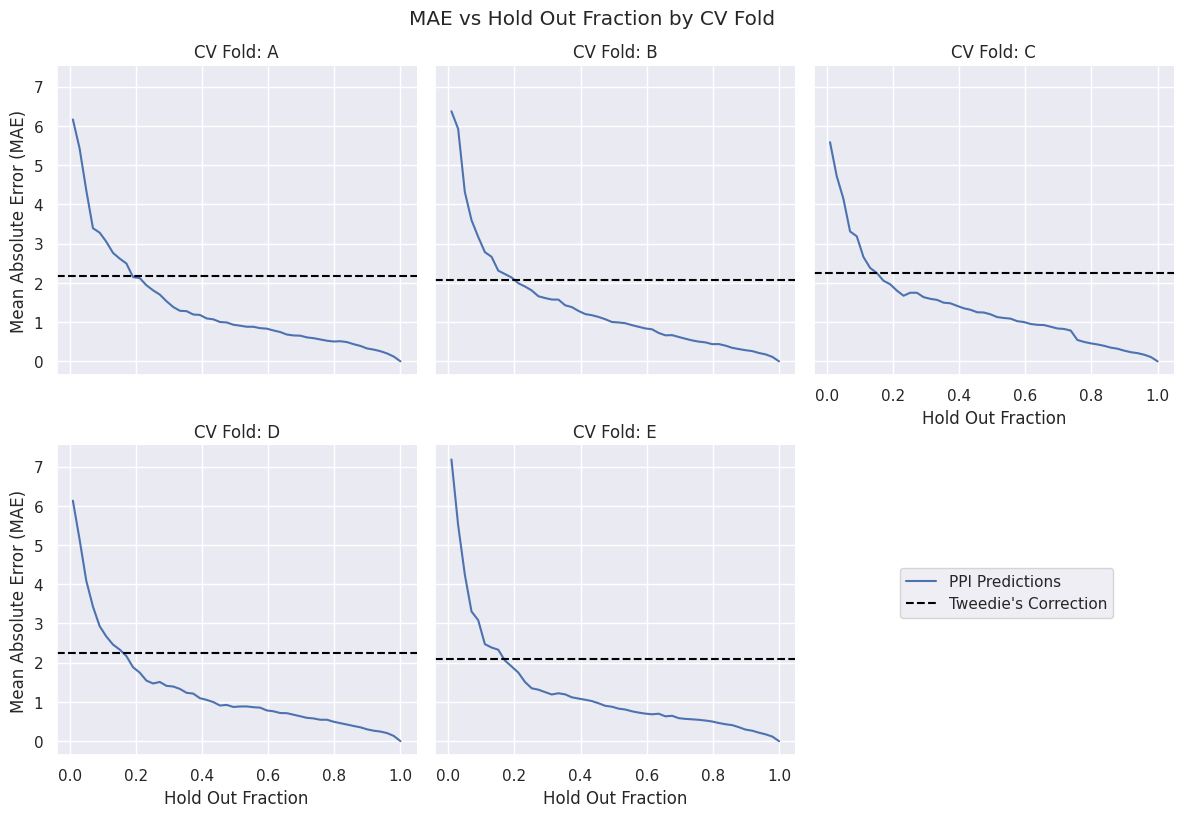

In [ ]:
g = sns.FacetGrid(ppi_stats_df, col="cv_fold", col_wrap=3, height=4, sharey=True)
g.map(sns.lineplot, "hold_out_frac", "mae")

# Add dashed horizontal lines for tweedie_train_iwi_hat MAE
for ax, cv_fold in zip(g.axes.flat, ppi_stats_df['cv_fold'].unique()):
    mae_value = metrics[(metrics['cv_fold'] == cv_fold) & (metrics['pred_type'] == 'tweedie_train_iwi_hat')]['mae'].values[0]
    ax.axhline(mae_value, color='black', linestyle='--', label='Tweedie Train MAE')

ppi_line_color = g.axes[0].lines[0].get_color()

# Create custom legend handles using actual line colors
custom_lines = [
    Line2D([0], [0], color=ppi_line_color, linestyle='-', label='PPI Predictions'),
    Line2D([0], [0], color='black', linestyle='--', label="Tweedie's Correction")
]

# Set labels and titles
g.set_axis_labels("Hold Out Fraction", "Mean Absolute Error (MAE)")
g.set_titles("CV Fold: {col_name}")
g.fig.suptitle("MAE vs Hold Out Fraction by CV Fold", y=1.02)

# Add custom legend to the figure
g.fig.legend(handles=custom_lines, loc='lower left', bbox_to_anchor=(0.75, 0.25))
plt.show()


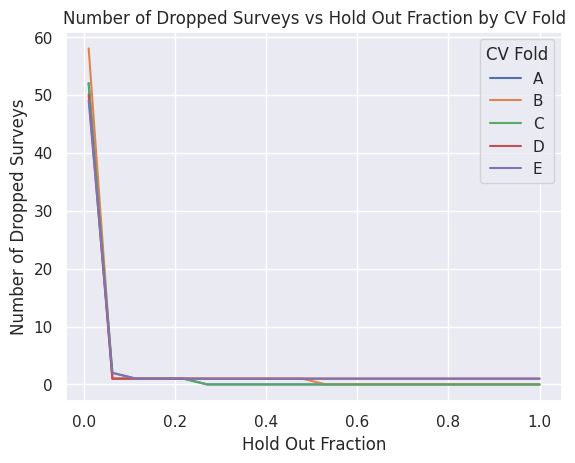

In [15]:
sns.lineplot(data=ppi_stats_df, x='hold_out_frac', y='n_dropped_surveys', hue='cv_fold')
plt.xlabel('Hold Out Fraction')
plt.ylabel('Number of Dropped Surveys')
plt.title('Number of Dropped Surveys vs Hold Out Fraction by CV Fold')
plt.legend(title='CV Fold')
plt.show()

In [16]:
metrics

,pred_type,cv_fold,mae,slope
0,iwi_hat,A,2.270104,0.860984
1,iwi_hat,B,2.275988,0.848135
2,iwi_hat,C,2.316853,0.877968
3,iwi_hat,D,2.347381,0.822339
4,iwi_hat,E,2.241685,0.851451
5,lcc_train_iwi_hat,A,2.048806,0.889561
6,lcc_train_iwi_hat,B,2.082678,0.901531
7,lcc_train_iwi_hat,C,2.175310,0.888037
8,lcc_train_iwi_hat,D,2.169614,0.859163
9,lcc_train_iwi_hat,E,2.194351,0.868064
